In [ ]:
# Part of download kaggle dataset

In [1]:
!pip install kaggle

In [2]:
import os

# Create a directory for Kaggle config
!mkdir ~/.kaggle

# Copy the kaggle.json file to the config directory
!cp kaggle.json ~/.kaggle/

# Set permissions for the kaggle.json file (important for security)
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d lyensoetanto/vehicle-images-dataset

Dataset URL: https://www.kaggle.com/datasets/lyensoetanto/vehicle-images-dataset
License(s): unknown
  0% 0.00/80.7M [00:00<?, ?B/s]
100% 80.7M/80.7M [00:00<00:00, 1.04GB/s]


In [4]:
!unzip vehicle-images-dataset.zip -d data/classification/raw/vehicle-images-dataset

Streaming output truncated to the last 5000 lines.
  inflating: data/classification/raw/vehicle-images-dataset/Sport Utility Vehicle/Image_011508.jpg  
  inflating: data/classification/raw/vehicle-images-dataset/Sport Utility Vehicle/Image_011509.jpg  
  inflating: data/classification/raw/vehicle-images-dataset/Sport Utility Vehicle/Image_011510.jpg  
  inflating: data/classification/raw/vehicle-images-dataset/Sport Utility Vehicle/Image_011511.jpg  
  inflating: data/classification/raw/vehicle-images-dataset/Sport Utility Vehicle/Image_011512.jpg  
  inflating: data/classification/raw/vehicle-images-dataset/Sport Utility Vehicle/Image_011513.jpg  
  inflating: data/classification/raw/vehicle-images-dataset/Sport Utility Vehicle/Image_011514.jpg  
  inflating: data/classification/raw/vehicle-images-dataset/Sport Utility Vehicle/Image_011515.jpg  
  inflating: data/classification/raw/vehicle-images-dataset/Sport Utility Vehicle/Image_011516.jpg  
  inflating: data/classification/raw/veh

In [5]:
# Main Code: Download Data
import os

# scripts/utils.py
import pandas as pd
import shutil

#model/models.py
import torch
import torch.nn as nn
from torchvision.models import ResNet18_Weights
from torchvision.models import resnet18

# model/classification/utils.py
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
import os
import pandas as pd
# from ..utils import save_model, load_model, writing_training_logs

#model/utils.py
# import torch

#model/train.py
import sys

# from .utils import CustomImageCarDataset, loss_epoch, plot_training_history, plot_metric_history, load_dataset, process_df, training_model,list_files_by_folder, preprocess_label
# from .model import build_model_classification


from pathlib import Path
# import torch
# import torch.nn as nn
import copy
from torch import optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
# import os

### Model/utils.py

In [ ]:
def save_model(model, path_to_save):
    """
    Save the model weights to the specified path.

    Args:
        model: The trained model.
        path_to_save: Path to save the model weights.
    """
    torch.save(model.state_dict(), path_to_save)
    print(f"Model weights saved to {path_to_save}")

def load_model(model, path_load_from, device):
    """
    Save the model weights to the specified path.

    Args:
        model: The trained model.
        path_to_save: Path to save the model weights.
    """
    # path_load_from = '/content/best_model_weights.pth'
    model.load_state_dict(torch.load(path_load_from, map_location=device))
    print(f"Model weights loaded successfully from {path_load_from}")

def writing_training_logs(path_to_save, message):
    """
    Write training logs to a file.

    Args:
        path_to_save: Path to save the training logs.
        message: Message to write in the log file.
    """
    with open(f'{path_to_save}', 'a') as f:
        f.write(message + '\n')
    # print(f"Training log saved: {message}")
    print(message)

def plot_loss_history(loss_history, path_to_save):
    """
    Plot the training and validation loss history.
    
    Args:
        loss_history: Dictionary containing training and validation loss history.
        path_to_save: Path to save the plot.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history['train'], label='Training Loss')
    plt.plot(loss_history['val'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss History')
    plt.legend()
    plt.grid()
    plt.savefig(f'{path_to_save}/loss_history.png')
    plt.show()

def plot_metric_history(metric_history, path_to_save):
    """
    Plot the training and validation metric history.
    
    Args:
        metric_history: Dictionary containing training and validation metric history.
        path_to_save: Path to save the plot.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(metric_history['train'], label='Training Metric')
    plt.plot(metric_history['val'], label='Validation Metric')
    plt.xlabel('Epochs')
    plt.ylabel('Metric')
    plt.title('Training and Validation Metric History')
    plt.legend()
    plt.grid()
    plt.savefig(f'{path_to_save}/metric_history.png')
    plt.show()

### model/classification/models.py

In [9]:
class BasicBlock(nn.Module):
    expansion = 1  # No channel expansion in BasicBlock

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64,  layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None

        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def build_model_classification(class_num=2, use_pretrained=True):
    # Create custom model
    custom_resnet18 = ResNet(BasicBlock, [2, 2, 2, 2], class_num)

    # Load pretrained weights from torchvision
    if use_pretrained:
        official_resnet18 = resnet18(weights=ResNet18_Weights.DEFAULT)

        pretrained_dict = official_resnet18.state_dict()
        model_dict = custom_resnet18.state_dict()

        #Filtered the last layer, because the difference number of class
        filtered_dict = {
            k: v for k, v in pretrained_dict.items()
            if k in model_dict and not k.startswith('fc')
        }

        custom_resnet18.load_state_dict(filtered_dict, strict=False)

    return custom_resnet18

### model/classification.utils.py

In [ ]:
class CustomImageCarDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.image_dir = image_dir
        self.df = df
        self.image_ids = list(self.df['image_id'])
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        records = self.df[self.df['image_id'] == image_id]

        image_path = f"{records['file_path'].values[0]}"
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)

        original_height, original_width = image.shape[:2]
        if original_height > 64 or original_width > 64:
            interpolation = cv2.INTER_AREA  # Downsampling
        else:
            interpolation = cv2.INTER_CUBIC  # Upsampling
        resized_image = cv2.resize(image, (64, 64), interpolation=interpolation)


        processed_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB).astype(np.float32)
        processed_image /= 255.0

        #Transpose the image tensor to be (channels, height, width)
        #from (height, width, channels)
        processed_image = processed_image.transpose((2, 0, 1))

        #Convert numpy array to torch tensor
        processed_image = torch.from_numpy(processed_image)

        labels = records['label_class'].values
        labels = torch.tensor(labels[0], dtype=torch.long)

        if self.transform:
            processed_image = self.transform(processed_image)

        return processed_image, labels

# Function to list files in each folder and return a DataFrame
def list_files_by_folder(base_path):
    """
    Lists all files in each subfolder of the given base path and returns a DataFrame.
    Args:
        base_path (str): The base directory containing subfolders with files.
    Returns:
        pd.DataFrame: A DataFrame with columns 'Folder' and 'File', where 'Folder' is the name of the subfolder
        and 'File' is the name of the file within that subfolder."""
    data = []

    # Iterate through each folder in the base path
    for folder_name in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder_name)

        # Check if it's a directory
        if os.path.isdir(folder_path):
            # List all files in the folder
            files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
            for file in files:
                data.append({"Folder": folder_name, "File": file})

    return pd.DataFrame(data)

def preprocess_label(cat):
    """
    Preprocesses the label category to a numerical format.
    Args:
        cat (str): The category label as a string.
    Returns:
        int: A numerical representation of the category.
    """
    match cat:
        case "City Car":
             return 0
        case "Big Truck":
             return 1
        case "Multi Purpose Vehicle":
             return 2
        case "Sedan":
            return 3
        case "Sport Utility Vehicle":
            return 4
        case "Truck":
            return 5
        case "Van":
            return 6

# Also define the metric_batch function, assuming it calculates accuracy per batch
def metric_batch(output, target, check_id):
    # calculate accuracy
    _, predicted = torch.max(output.data, 1)

    target_squeezed = target.squeeze()
    if predicted.shape != target_squeezed.shape:
        pass

    correct = (predicted == target.squeeze()).sum().item()
    metric_b = correct / target.size(0)
    return metric_b


def loss_epoch(model, loss_func, data_loader, sanity_check=False, opt=None, device=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(data_loader.dataset)

    for i, (inputs, labels) in enumerate(data_loader):
        # Move inputs and labels to the specified device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # If in training phase, zero the gradients
        if opt is not None:
            opt.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss for the batch
        loss = loss_func(outputs, labels)

        # Calculate the metric for the batch
        metric_b = metric_batch(outputs, labels, None)

        # Backward pass and optimizer step (if training)
        if opt is not None:
            loss.backward()
            opt.step()

        # Accumulate the running loss and metric
        running_loss += loss.item() * inputs.size(0)  # Multiply by batch size
        running_metric += metric_b * inputs.size(0)  # Multiply by batch size

        # If sanity check is enabled, break after one batch
        if sanity_check:
            break

    # Calculate the average loss and metric for the epoch
    loss = running_loss / len_data
    metric = running_metric / len_data

    return loss, metric

def load_dataset(base_path):
    """Loads the dataset from the specified base path and returns DataFrames for train, validation, and test sets."""

    df_train = process_df(base_path, 'train')
    df_val = process_df(base_path, 'val')
    # df_test = process_df(base_path, 'test')

    return df_train, df_val

def process_df(base_path, type_dataset):
    """Processes the DataFrame to include the full file path for images."""


    df = list_files_by_folder(f"{base_path}/{type_dataset}")
    df['label_class'] = df['Folder'].apply(lambda cat: preprocess_label(cat))
    df = df.reset_index()
    df.columns = ['image_id', 'class_name', 'file_name', 'label_class']
    df['file_path'] = df.apply(lambda row: f"{base_path}/{type_dataset}/{row['class_name']}/{row['file_name']}", axis=1)

    return df

def training_model(train_dl,
                   valid_dl,
                   model,
                   optimiser,
                   device,
                   num_epochs=2,
                   lr_scheduler=None,
                   loss_func=None,
                   path_to_save=None):
    loss_history={"train": [],"val": []} # history of loss values in each epoch
    metric_history={"train": [],"val": []}
    best_loss=float('inf')

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        model.train()  # Set the model to training mode
        # Path to save : root_dir + /logs/classification
        writing_training_logs(f'{path_to_save}/training_history/training_logs.txt',
                                f"Starting Epoch #{epoch+1}...")
        print(f"Starting training for Epoch #{epoch+1}...")
        train_loss, train_metric = loss_epoch(model,
                                              loss_func,
                                              train_dl,
                                              sanity_check=False,
                                              opt=optimiser,
                                              device=device)

        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)

        # learning rate schedule
        if lr_scheduler is not None:
            lr_scheduler.step()

        print(f"Epoch #{epoch+1} Training loss: {train_loss}, Training metric: {train_metric}")
        writing_training_logs(f'{path_to_save}/training_history/training_logs.txt',
                              f"Epoch #{epoch+1} Training loss: {train_loss:.4f}, Training metric: {train_metric}")

        # evaluate model on validation dataset

        writing_training_logs(f'{path_to_save}/training_history/training_logs.txt',
                              f"Start validation for Epoch #{epoch+1}...")
        print(f"Starting validation for Epoch #{epoch+1}...")

        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,
                                            loss_func,
                                            valid_dl,
                                            sanity_check=False,
                                            opt=None,
                                            device=device)

        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        print(f"Epoch #{epoch+1} Validation loss: {val_loss}, Validation metric: {val_metric}")
        writing_training_logs(f'{path_to_save}/training_history/training_logs.txt',
                              f"Epoch #{epoch+1} Validation loss: {val_loss:.4f}, Validation metric: {val_metric:.4f}")
        # store best model
        if val_loss < best_loss:
            best_loss = val_loss

            writing_training_logs(f'{path_to_save}/training_history/training_logs.txt',
                                  f"New best validation loss: {best_loss:.4f} at epoch #{epoch+1}. Saving model...")
            print(f"New best validation loss: {best_loss:.4f} at epoch #{epoch+1}. Saving model...")

            save_model(model, f"{path_to_save}/best_model/best_model_weights.pth")
            # torch.save(model.state_dict(), path)
            # if(verbose):
            print("Copied best model weights!")

        writing_training_logs(f'{path_to_save}/training_history/training_logs.txt',
                              f"train loss: {train_loss:.6f}, val loss: {val_loss:.6f}, accuracy validation: {100*val_metric:.2f}")

    writing_training_logs(f"{path_to_save}/training_history/training_logs.txt", 'Finished Training')
    return loss_history, metric_history

### Scripts/utils.py

In [ ]:
# Function to list files in each folder and return a DataFrame
def list_files_by_folder(base_path):
    """
    Lists all files in each subfolder of the given base path and returns a DataFrame.
    Args:
        base_path (str): The base directory containing subfolders with files.
    Returns:
        pd.DataFrame: A DataFrame with columns 'Folder' and 'File', where 'Folder' is the name of the subfolder
        and 'File' is the name of the file within that subfolder."""
    data = []

    # Iterate through each folder in the base path
    for folder_name in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder_name)

        # Check if it's a directory
        if os.path.isdir(folder_path):
            # List all files in the folder
            files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
            for file in files:
                data.append({"Folder": folder_name, "File": file})

    return pd.DataFrame(data)

def assign_set_refactored(group, ratio=0.8, first_group='Training', second_group='Test'):
    """Assigns a set group to each item in the group based on the specified ratio.
    Args:
        group (pd.DataFrame): A DataFrame group containing items to be assigned to sets.
        ratio (float): The ratio of the first group size to the total size of the group. Default is 0.8.
        first_group (str): The name of the first group to assign. Default is 'Training'.
        second_group (str): The name of the second group to assign. Default is 'Test'.
    Returns:
        pd.Series: A Series with the same index as the group, containing the assigned set group names.
    """
    split_index = int(len(group) * ratio)  # 80% for training
    # Create a Series to hold the set assignments for this group
    set_assignments = pd.Series(index=group.index, dtype='object')
    set_assignments.iloc[:split_index] = first_group
    set_assignments.iloc[split_index:] = second_group

    return set_assignments

def preprocess_label(cat):
    """
    Preprocesses the label category to a numerical format.
    Args:
        cat (str): The category label as a string.
    Returns:
        int: A numerical representation of the category.
    """
    match cat:
        case "City Car":
             return 0
        case "Big Truck":
             return 1
        case "Multi Purpose Vehicle":
             return 2
        case "Sedan":
            return 3
        case "Sport Utility Vehicle":
            return 4
        case "Truck":
            return 5
        case "Van":
            return 6

def copy_images_to_split_dirs(df, dataset_type, original_base_path, new_base_path):
    """
    Copies images from original dataset path to new split directories based on DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing image information and split group.
        dataset_type (str): The type of dataset ('train', 'val', 'test').
        original_base_path (str): The base directory of the original dataset.
        new_base_path (str): The base directory where the new split dataset will be created.
    """
    print(f"Copying {dataset_type} images...")
    count = 0
    for index, row in df.iterrows():
        class_name = row['class_name']
        file_name = row['file_name']

        # Original image path
        original_image_path = os.path.join(original_base_path, class_name, file_name)

        # New image path
        new_dataset_type_dir = os.path.join(new_base_path, dataset_type)
        new_class_dir = os.path.join(new_dataset_type_dir, class_name)
        new_image_path = os.path.join(new_class_dir, file_name)

        # Create target class directory if it doesn't exist
        os.makedirs(new_class_dir, exist_ok=True)

        # Check if original file exists before copying
        if os.path.exists(original_image_path):
            # Copy the image file
            try:
                shutil.copy2(original_image_path, new_image_path)
                count += 1
            except Exception as e:
                print(f"Error copying {original_image_path} to {new_image_path}: {e}")
        else:
            print(f"Warning: Original file not found: {original_image_path}")

    print(f"Finished copying {count} {dataset_type} images.")

def move_dataset_detection(source_folder, destination_folder, remove=False):
    """
    Moves specified folders from the source directory to the destination directory.
    Args:
        source_folder (str): The path to the source directory containing the dataset.
        destination_folder (str): The path to the destination directory where folders will be copied.
        remove (bool): If True, removes the source directory after copying. Default is False.
    """
    source_dir = source_folder
    destination_dir = destination_folder

    # Define the folders to copy
    folders_to_copy = ['test', 'train', 'valid']

    print(f"Contents of the downloaded directory: {source_dir}")
    try:
        print(os.listdir(source_dir))
    except FileNotFoundError:
        print(f"Error: The source directory {source_dir} was not found.")


    # Copy each folder
    for folder in folders_to_copy:
        source_folder_path = os.path.join(source_dir, folder)
        destination_folder_path = os.path.join(destination_dir, folder)
        print(f"Copying {source_folder_path} to {destination_folder_path}")
        try:
            shutil.copytree(source_folder_path, destination_folder_path, dirs_exist_ok=True)
        except FileNotFoundError:
            print(f"Error: Source folder {source_folder_path} not found. Please check the directory structure of the downloaded dataset.")


    print("Finished copying specified folders.")

    # Delete the source folder
    # Remove the source directory and its contents
    
    if remove:
        if os.path.exists(source_dir):
            print(f"Removing source directory: {source_dir}")
            shutil.rmtree(source_dir)
            print(f"Source directory {source_dir} removed successfully.")
        else:
            print(f"Source directory {source_dir} does not exist. No action needed.")

## Main Code

In [ ]:
project_dir = os.getcwd()

### Scripts/download_data_classification.py

In [ ]:

source_dir = f'{project_dir}/data/classification/raw/vehicle-images-dataset'

dataset_df = list_files_by_folder(source_dir)
dataset_df['Set'] = None  # Initialize the 'Set' column

# Shuffle the DataFrame to randomize the order
dataset_df = dataset_df.sample(frac=1, random_state=42).reset_index(drop=True)

dataset_df['label_class'] = dataset_df['Folder'].apply(lambda cat: preprocess_label(cat))
dataset_df['Set'] = dataset_df.groupby('Folder', group_keys=False).apply(assign_set_refactored)

dataset_df = dataset_df.reset_index()
dataset_df.columns=['image_id','class_name', 'file_name', 'set_group','label_class']

# Split the dataset into training and test sets
df_train = dataset_df[dataset_df['set_group']=="Training"]
df_test_all = dataset_df[dataset_df['set_group']=="Test"]

# Assign the set group for the test set, ensuring a 50/50 split between Test and Validation
df_test_all['set_group'] = df_test_all.groupby('class_name', group_keys=False).apply(assign_set_refactored, ratio=0.5, first_group='Test', second_group='Validation')

# Split the dataset into training and test sets
df_val = df_test_all[df_test_all['set_group']=="Validation"]
df_test = df_test_all[df_test_all['set_group']=="Test"]

# Define the base directory for the new split dataset
destination_dir = f'{project_dir}/data/classification'

# Ensure the base directory for the new split dataset exists
os.makedirs(destination_dir, exist_ok=True)

# Copy images for each split
copy_images_to_split_dirs(df_train, 'train', source_dir, destination_dir)
copy_images_to_split_dirs(df_val, 'val', source_dir, destination_dir)
copy_images_to_split_dirs(df_test, 'test', source_dir, destination_dir)

print("Dataset for Image Classification has been successfully created and images copied to respective directories.")

<ipython-input-7-4a4c2ee8301f>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dataset_df['Set'] = dataset_df.groupby('Folder', group_keys=False).apply(assign_set_refactored)
<ipython-input-7-4a4c2ee8301f>:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_test_all['set_group'] = df_test_all.groupby('class_name', group_keys=False).apply(assign_set_refactored, ratio=0.5, first_group='Test', second_group=

Copying train images...
Finished copying 12513 train images.
Copying val images...
Finished copying 1566 val images.
Copying test images...
Finished copying 1566 test images.
Dataset for Image Classification has been successfully created and images copied to respective directories.


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
device

device(type='cuda')

### model/classification/train.py

current lr = 0.0001
Ensured directories exist: /content/logs/classification/training_history, /content/logs/classification/best_model
Starting Epoch #1...
Starting training for Epoch #1...
Epoch #1 Training loss: 27.4238805373605, Training metric: 0.6691440901462479
Epoch #1 Training loss: 27.4239, Training metric: 0.6691440901462479
Start validation for Epoch #1...
Starting validation for Epoch #1...
Epoch #1 Validation loss: 14.838740773889144, Validation metric: 0.8243933588761175
Epoch #1 Validation loss: 14.8387, Validation metric: 0.8244
New best validation loss: 14.8387 at epoch #1. Saving model...
New best validation loss: 14.8387 at epoch #1. Saving model...
Model weights saved to /content/logs/classification/best_model/best_model_weights.pth
Copied best model weights!
train loss: 27.423881, val loss: 14.838741, accuracy validation: 82.44
Starting Epoch #2...
Starting training for Epoch #2...
Epoch #2 Training loss: 8.031522784960563, Training metric: 0.9140094301925997
Epoch 

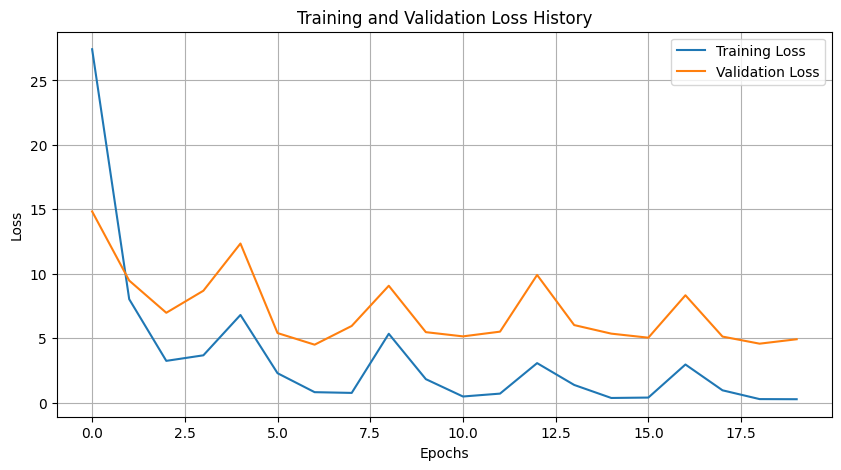

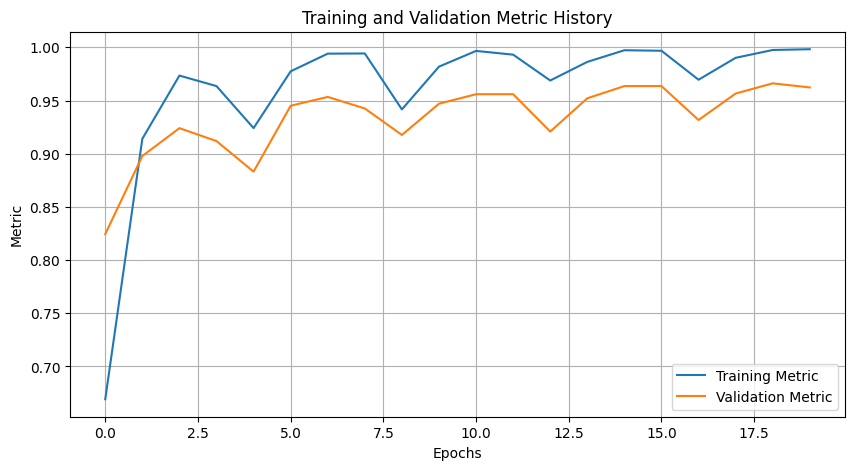

In [ ]:
# current_file_path = Path(__file__)
# project_dir = current_file_path.parent.parent.parent


source_dir = f'{project_dir}/data/classification'
df_train, df_val = load_dataset(source_dir)

def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

class_names = {
    0: 'City Car',
    1: 'Big Truck',
    2: 'Multi Purpose Vehicle',
    3: 'Sedan',
    4: 'Sport Utility Vehicle',
    5: 'Truck',
    6: 'Van'
}
num_classes=len(class_names)

# Create Dataset
train_dataset = CustomImageCarDataset(df_train, source_dir, None)
val_dataset = CustomImageCarDataset(df_val, source_dir, None)

# Create Data Loaders (training)
train_dl = DataLoader(train_dataset,
                      batch_size=32,
                      shuffle=True)

# Create Data Loader (validation)
val_dl = DataLoader(val_dataset,
                    batch_size=32,
                    shuffle=False)



model = build_model_classification(class_num=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

# defining loss function
loss_func = nn.CrossEntropyLoss(reduction='sum')

# defining optimiser
optimiser= optim.Adam(model.parameters(),
                 lr=1e-4)

current_lr = get_lr(optimiser)
print(f'current lr = {current_lr}')

# Define learning rate
lr_scheduler = CosineAnnealingLR(optimiser,
                                 T_max=2,
                                 eta_min=1e-5)
# Defining epoch
epochs = 20

loss_history={"train": [],"val": []} # history of loss values in each epoch
metric_history={"train": [],"val": []} # histroy of metric values in each epoch
best_loss=float('inf') # initialize best loss to a large value

# Create directories for saving logs and best model if they don't exist
logs_dir = f"{project_dir}/logs/classification"
training_history_dir = f"{logs_dir}/training_history"
best_model_dir = f"{logs_dir}/best_model"

os.makedirs(logs_dir, exist_ok=True)
os.makedirs(training_history_dir, exist_ok=True)
os.makedirs(best_model_dir, exist_ok=True)


print(f"Ensured directories exist: {training_history_dir}, {best_model_dir}")


loss_history, metric_history = training_model(
    train_dl,
    val_dl,
    model,
    optimiser,
    device,
    num_epochs=epochs,
    lr_scheduler=lr_scheduler,
    loss_func=loss_func,
    path_to_save=f"{logs_dir}")

plot_loss_history(loss_history, training_history_dir)
plot_metric_history(metric_history, training_history_dir)

### Model/classification/eval.py

In [ ]:
class_names = {
    0: 'City Car',
    1: 'Big Truck',
    2: 'Multi Purpose Vehicle',
    3: 'Sedan',
    4: 'Sport Utility Vehicle',
    5: 'Truck',
    6: 'Van'
}
num_classes=len(class_names)
task_name = 'classification'

# current_file_path = Path(__file__)
# project_dir = current_file_path.parent.parent.parent

source_dir = f'{project_dir}/data/classification'

df_test = process_df(source_dir, 'test')
test_dataset = CustomImageCarDataset(df_test, source_dir, None)

# Create Data Loader (validation)
test_dl = DataLoader(test_dataset,
                    batch_size=32,
                    shuffle=False)


model = build_model_classification(class_num=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


load_model(model, f"{project_dir}/logs/{task_name}/best_model/best_model_weights.pth", device)
model = model.to(device)

model.eval()
loss_fn = nn.CrossEntropyLoss()

test_loss, test_metric = loss_epoch(model, loss_fn, test_dl, sanity_check=False, opt=None, device=device)

print(f"Test Loss: {test_loss}, Test Metric: {test_metric}")